# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import shutil
import urllib
import zipfile
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.utils import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Embedding, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    # os.environ["TF_DETERMINISTIC_OPS"] = "1" ### can make training slower


set_reproducibility(seed=42)

# [Task 1 - 0.5 points] Corpus

### Download the corpus

In [3]:
def download_url(download_path: Path, url: str):
    urllib.request.urlretrieve(url, filename=download_path)

In [4]:
dataset_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

dataset_folder = Path.cwd().joinpath("Datasets")
if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
if not dataset_zip_path.exists():
    print("Downloading dataset... ", end="")
    download_url(url=dataset_url, download_path=dataset_zip_path)
    print("Download complete!")
else:
    print("Dataset already downloaded!")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_path.exists():
    print("Extracting dataset... (it may take a while...) ", end="")
    shutil.unpack_archive(dataset_zip_path, dataset_folder)
    print("Extraction completed!")
else:
    print("Dataset already extracted!")

Extracting dataset... (it may take a while...) Extraction completed!


#### Encode the corpus into a pandas DataFrame object

In [5]:
folder = dataset_folder.joinpath(dataset_name)


dataframe_rows = []
for file_path in sorted(folder.glob("*.dp")):
    with file_path.open(mode="r", encoding="utf-8") as text_file:
        text = text_file.read()
        ### Split sentences (\n\n is used for most NLP datasets to split sentences)
        sentences = text.split("\n\n")

        ### Observing each sentence
        for s in sentences:
            sentence = []
            tags = []
            ### Taking every line
            for line in s.split("\n"):
                columns = line.split("\t")
                ### If every line have word, tag, value
                if len(columns) > 2:
                    ### Put words and tags into lists
                    sentence.append(columns[0])
                    tags.append(columns[1])

            file_id = int(file_path.stem.split("_")[1])
            dataframe_row = {"file_id": file_id, "sentence": sentence, "tag": tags}
            dataframe_rows.append(dataframe_row)

df = pd.DataFrame(dataframe_rows)

FILE_ID, SENTENCE, TAGS = df.columns.values

In [6]:
df.head()

,file_id,sentence,tag
0,1,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,3,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


#### Splitting Data Train-Test-Validation

In [7]:
### File indices for train/validation/test
train_ids = np.arange(1, 101)
val_ids = np.arange(101, 151)
test_ids = np.arange(151, 200)

df_train = df[df[FILE_ID].isin(train_ids)]
df_val = df[df[FILE_ID].isin(val_ids)]
df_test = df[df[FILE_ID].isin(test_ids)]

# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [8]:
### Download Glove

embedding_dim = 100
glove_file = f"glove.6B.{embedding_dim}d.txt"
glove_zip = "glove.6B.zip"
glove_path = Path.cwd().joinpath(glove_file)
if not glove_path.exists():
    urllib.request.urlretrieve(
        "http://nlp.stanford.edu/data/glove.6B.zip", Path.cwd().joinpath(glove_zip)
    )
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extractall()

In [9]:
embeddings_index = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [10]:
# max_sequence_length = int(np.quantile([len(seq) for seq in df_train[SENTENCE]], 0.99))
max_sequence_length = max([len(seq) for seq in df_train[SENTENCE]])

In [11]:
### Preprocessing: lowercase
def make_lower(df):
    df[SENTENCE].apply(lambda l: [i.lower() for i in l])


make_lower(df_train)
make_lower(df_val)
make_lower(df_test)

In [12]:
### Use Keras Tokenizer to create Vocabulary


tokenizer = Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(df_train[SENTENCE])

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(df_train[TAGS])


### Turn text into into padded sequences.
def prep_text(texts, tokenizer, max_sequence_length):
    text_sequences = tokenizer.texts_to_sequences(texts)
    return sequence.pad_sequences(
        text_sequences, maxlen=max_sequence_length, padding="post"
    )


text_train = prep_text(df_train[SENTENCE], tokenizer, max_sequence_length)
text_test = prep_text(df_test[SENTENCE], tokenizer, max_sequence_length)
text_val = prep_text(df_val[SENTENCE], tokenizer, max_sequence_length)

tag_train = prep_text(df_train[TAGS], tag_tokenizer, max_sequence_length)
tag_test = prep_text(df_test[TAGS], tag_tokenizer, max_sequence_length)
tag_val = prep_text(df_val[TAGS], tag_tokenizer, max_sequence_length)

In [13]:
tag_train.shape
tag_train[0]

array([ 2,  2,  7, 11,  5,  6,  7, 20, 12,  4,  1,  3,  4,  6,  1,  2, 11,
        8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [14]:
### Encode the tags in 1hot encoding

num_classes = len(tag_tokenizer.word_index) + 1
tag_categorical_train = to_categorical(tag_train, num_classes)
tag_categorical_test = to_categorical(tag_test, num_classes)
tag_categorical_val = to_categorical(tag_val, num_classes)

In [15]:
all_classes = list(tag_tokenizer.word_index.keys())
all_tokens = list(tag_tokenizer.word_index.values())
punct_classes = [",", ".", ":", "``", "''", "$", "#", "sym", "-rrb-", "-lrb-"]
punct_tokens = [tag_tokenizer.word_index[p] for p in punct_classes]
allowed_classes = [
    word for word in tag_tokenizer.index_word.values() if word not in punct_classes
]
allowed_tokens = [token for token in all_tokens if token not in punct_tokens]

print(f"Tags: {all_classes}")
print(f"All tag-tokens: {all_tokens}\n")
print(f"Punctuations: {punct_classes}")
print(f"Tokenized punctuations {punct_tokens}\n")
print(f"Tags without punctuation: {allowed_classes}")
print(f"Tokens will be used in evaluations: {allowed_tokens}")

Tags: ['nn', 'nnp', 'in', 'dt', 'nns', 'jj', ',', '.', 'vbd', 'rb', 'cd', 'vb', 'cc', 'vbz', 'vbn', 'to', 'prp', 'vbg', 'vbp', 'md', 'prp$', '``', 'pos', "''", '$', ':', 'wdt', 'jjr', 'wp', 'rp', 'nnps', 'jjs', 'wrb', 'rbr', '-rrb-', '-lrb-', 'ex', 'rbs', 'ls', 'pdt', 'wp$', 'fw', 'uh', 'sym', '#']
All tag-tokens: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

Punctuations: [',', '.', ':', '``', "''", '$', '#', 'sym', '-rrb-', '-lrb-']
Tokenized punctuations [7, 8, 26, 22, 24, 25, 45, 44, 35, 36]

Tags without punctuation: ['nn', 'nnp', 'in', 'dt', 'nns', 'jj', 'vbd', 'rb', 'cd', 'vb', 'cc', 'vbz', 'vbn', 'to', 'prp', 'vbg', 'vbp', 'md', 'prp$', 'pos', 'wdt', 'jjr', 'wp', 'rp', 'nnps', 'jjs', 'wrb', 'rbr', 'ex', 'rbs', 'ls', 'pdt', 'wp$', 'fw', 'uh']
Tokens will be used in evaluations: [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 27,

In [16]:
### Create the embedding matrix
embeddings_index = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [17]:
### Inspect tokens' embedding vectors
idx_token = 2
print(
    f"Token: {list(tokenizer.word_index.keys())[idx_token]} \nVector: {embedding_matrix[idx_token]}"
)

Token: the 
Vector: [-0.10767     0.11053     0.59811997 -0.54360998  0.67395997  0.10663
  0.038867    0.35481     0.06351    -0.094189    0.15786    -0.81664997
  0.14172     0.21939     0.58504999 -0.52157998  0.22782999 -0.16642
 -0.68228     0.35870001  0.42568001  0.19021     0.91962999  0.57555002
  0.46184999  0.42363    -0.095399   -0.42749    -0.16566999 -0.056842
 -0.29595     0.26036999 -0.26605999 -0.070404   -0.27662     0.15820999
  0.69825     0.43081     0.27952    -0.45436999 -0.33801001 -0.58183998
  0.22363999 -0.57779998 -0.26862001 -0.20424999  0.56393999 -0.58524001
 -0.14365    -0.64218003  0.0054697  -0.35247999  0.16162001  1.1796
 -0.47674    -2.75530005 -0.1321     -0.047729    1.06550002  1.10339999
 -0.2208      0.18669     0.13177     0.15117     0.71310002 -0.35214999
  0.91347998  0.61782998  0.70991999  0.23954999 -0.14571001 -0.37858999
 -0.045959   -0.47367999  0.2385      0.20536    -0.18996     0.32506999
 -1.11119998 -0.36341     0.98679    -0.084

# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

In [19]:
def get_model(lstm_units=64, add_lstm=False, add_dense=False):
    number_of_words = len(tokenizer.word_index.keys())
    number_of_tags = len(tag_tokenizer.word_index.keys())

    input = Input(shape=(max_sequence_length,))

    embedding_layer = Embedding(
        input_dim=number_of_words + 1,
        output_dim=embedding_dim,
        input_length=max_sequence_length,
        weights=[embedding_matrix],
        trainable=False,
    )(input)
    bi_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
    bi_lstm2 = (
        Bidirectional(LSTM(lstm_units, return_sequences=True))(bi_lstm)
        if add_lstm
        else bi_lstm
    )
    dense2 = (
        TimeDistributed(Dense(number_of_tags + 1, activation="relu"))(bi_lstm2)
        if add_dense
        else bi_lstm
    )
    dense_output = TimeDistributed(Dense(number_of_tags + 1, activation="softmax"))(
        dense2
    )
    model = Model(input, dense_output)

    model.compile(
        loss=CategoricalCrossentropy(from_logits=False),
        optimizer=Adam(5e-3),
        metrics=["accuracy"],
    )
    # model.summary()
    return model

In [20]:
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=20,
    restore_best_weights=True,
    min_delta=0.001,
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    mode="max",
    factor=0.1,
    patience=7,
    cooldown=1,
    min_lr=1e-5,
    min_delta=0.001,
)

In [21]:
### Class weights
tags_train_flatten = np.array(
    df_train[TAGS]
    .apply(lambda l: l + ["zzzzzz" for _ in range(len(tag_train[0]) - len(l))])
    .to_list()
).flatten()

tags_train_flatten = tags_train_flatten[tags_train_flatten != "zzzzzz"]
unique_tags = np.unique(tags_train_flatten)
weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_tags,
    y=tags_train_flatten,
)
class_weights = {
    idx: weight
    for idx, weight in zip(range(len(unique_tags) + 1), np.append(weights, (1.0)))
}

# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)

In [22]:
def metric(model, text, tag_categorical, labels=None):

    y_pred = model.predict([text]).argmax(-1).flatten()
    y_test_flatten = tag_categorical.argmax(-1).flatten()
    score = f1_score(
        y_test_flatten,
        y_pred,
        labels=labels,  ### allowed tokens
        average="macro",
        zero_division=0,
    )

    return score

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

In [23]:
def experiment(seed, model1=False, model2=False):
    set_reproducibility(seed)

    model = get_model(add_lstm=model1, add_dense=model2)

    ### Train model on the train set
    history = model.fit(
        text_train,
        tag_categorical_train,
        batch_size=128,
        epochs=50,
        validation_data=(text_val, tag_categorical_val),
        callbacks=[early_stopping, reduce_lr],
        # class_weight=class_weights,
    )

    ### Compute metrics
    score = metric(model, text_val, tag_categorical_val)

    return score, history, model

In [24]:
seeds = [333, 666, 999]
seeds = [333]

In [25]:
### Baseline experiment

baseline_results = [experiment(s) for s in seeds]
baseline_scores = [r[0] for r in baseline_results]
baseline_histories = [r[1] for r in baseline_results]
baseline_models = [r[2] for r in baseline_results]

Epoch 1/50
16/16 [==============================] - 8s 98ms/step - loss: 1.3043 - accuracy: 0.8939 - val_loss: 0.2633 - val_accuracy: 0.9388 - lr: 0.0050
Epoch 2/50
16/16 [==============================] - 1s 33ms/step - loss: 0.2320 - accuracy: 0.9459 - val_loss: 0.2032 - val_accuracy: 0.9518 - lr: 0.0050
Epoch 3/50
16/16 [==============================] - 1s 33ms/step - loss: 0.1718 - accuracy: 0.9567 - val_loss: 0.1549 - val_accuracy: 0.9587 - lr: 0.0050
Epoch 4/50
16/16 [==============================] - 1s 32ms/step - loss: 0.1283 - accuracy: 0.9674 - val_loss: 0.1238 - val_accuracy: 0.9674 - lr: 0.0050
Epoch 5/50
16/16 [==============================] - 1s 34ms/step - loss: 0.0999 - accuracy: 0.9756 - val_loss: 0.1028 - val_accuracy: 0.9733 - lr: 0.0050
Epoch 6/50
16/16 [==============================] - 1s 33ms/step - loss: 0.0812 - accuracy: 0.9804 - val_loss: 0.0890 - val_accuracy: 0.9767 - lr: 0.0050
Epoch 7/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0

0.6810843406962791


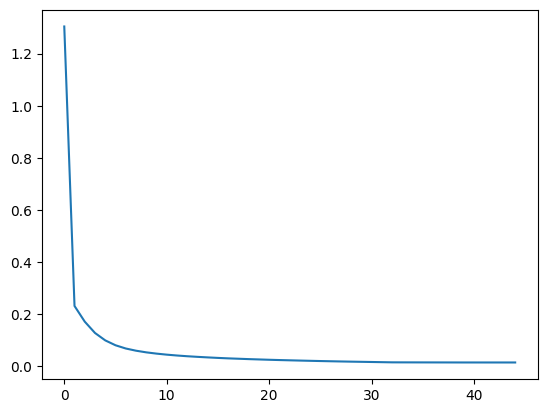

In [26]:
[print(h) for h in baseline_scores]
[plt.plot(h.history["loss"]) for h in baseline_histories]

plt.show()

In [27]:
### Model1 experiment

model1_results = [experiment(s, model1=True) for s in seeds]
model1_scores = [r[0] for r in model1_results]
model1_histories = [r[1] for r in model1_results]
model1_models = [r[2] for r in model1_results]

Epoch 1/50
16/16 [==============================] - 5s 97ms/step - loss: 1.3183 - accuracy: 0.8968 - val_loss: 0.2582 - val_accuracy: 0.9416 - lr: 0.0050
Epoch 2/50
16/16 [==============================] - 1s 32ms/step - loss: 0.2290 - accuracy: 0.9463 - val_loss: 0.2052 - val_accuracy: 0.9506 - lr: 0.0050
Epoch 3/50
16/16 [==============================] - 1s 34ms/step - loss: 0.1763 - accuracy: 0.9555 - val_loss: 0.1607 - val_accuracy: 0.9576 - lr: 0.0050
Epoch 4/50
16/16 [==============================] - 1s 33ms/step - loss: 0.1344 - accuracy: 0.9659 - val_loss: 0.1297 - val_accuracy: 0.9660 - lr: 0.0050
Epoch 5/50
16/16 [==============================] - 1s 33ms/step - loss: 0.1053 - accuracy: 0.9737 - val_loss: 0.1079 - val_accuracy: 0.9724 - lr: 0.0050
Epoch 6/50
16/16 [==============================] - 1s 32ms/step - loss: 0.0855 - accuracy: 0.9791 - val_loss: 0.0930 - val_accuracy: 0.9758 - lr: 0.0050
Epoch 7/50
16/16 [==============================] - 1s 33ms/step - loss: 0.0

0.6820009291283367


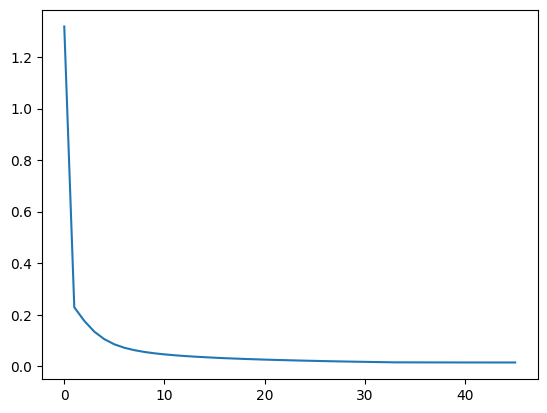

In [28]:
[print(h) for h in model1_scores]
[plt.plot(h.history["loss"]) for h in model1_histories]
plt.show()

In [29]:
### Model2 experiment
model2_results = [experiment(s, model2=True) for s in seeds]
model2_scores = [r[0] for r in model2_results]
model2_histories = [r[1] for r in model2_results]
model2_models = [r[2] for r in model2_results]

Epoch 1/50
16/16 [==============================] - 8s 144ms/step - loss: 1.3920 - accuracy: 0.8900 - val_loss: 0.2807 - val_accuracy: 0.9202 - lr: 0.0050
Epoch 2/50
16/16 [==============================] - 1s 55ms/step - loss: 0.2511 - accuracy: 0.9352 - val_loss: 0.2237 - val_accuracy: 0.9403 - lr: 0.0050
Epoch 3/50
16/16 [==============================] - 1s 55ms/step - loss: 0.1908 - accuracy: 0.9498 - val_loss: 0.1701 - val_accuracy: 0.9542 - lr: 0.0050
Epoch 4/50
16/16 [==============================] - 1s 55ms/step - loss: 0.1430 - accuracy: 0.9612 - val_loss: 0.1334 - val_accuracy: 0.9635 - lr: 0.0050
Epoch 5/50
16/16 [==============================] - 1s 44ms/step - loss: 0.1081 - accuracy: 0.9718 - val_loss: 0.1082 - val_accuracy: 0.9706 - lr: 0.0050
Epoch 6/50
16/16 [==============================] - 1s 35ms/step - loss: 0.0847 - accuracy: 0.9781 - val_loss: 0.0914 - val_accuracy: 0.9753 - lr: 0.0050
Epoch 7/50
16/16 [==============================] - 1s 34ms/step - loss: 0.

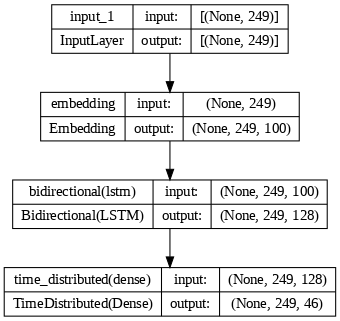

In [30]:
plot_model(baseline_models[0], show_shapes=True, dpi=76, to_file="baseline.png")

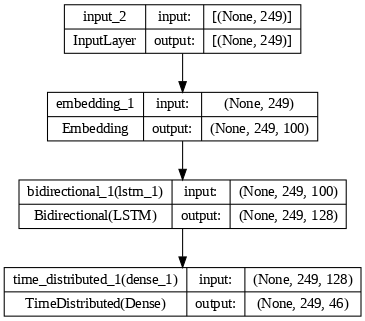

In [31]:
plot_model(model1_models[0], show_shapes=True, dpi=76, to_file="model1.png")

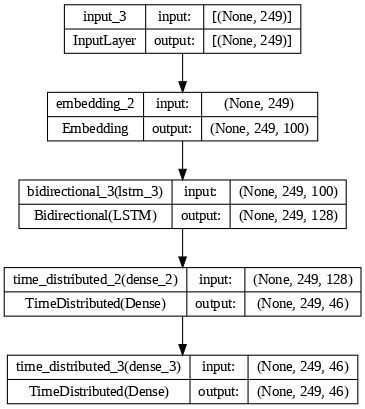

In [32]:
plot_model(model2_models[0], show_shapes=True, dpi=76, to_file="model2.png")

0.6792002004566685


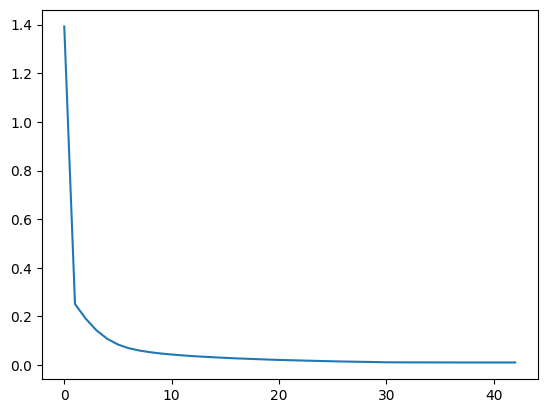

In [33]:
[print(h) for h in model2_scores]
[plt.plot(h.history["loss"]) for h in model2_histories]
plt.show()

In [34]:
### Compute metrics on validation set

baseline_val_metrics = [
    metric(m, text_val, tag_categorical_val, labels=allowed_tokens)
    for m in baseline_models
]
model1_val_metrics = [
    metric(m, text_val, tag_categorical_val, labels=allowed_tokens)
    for m in model1_models
]
model2_val_metrics = [
    metric(m, text_val, tag_categorical_val, labels=allowed_tokens)
    for m in model2_models
]

baseline_val_avg = np.average(baseline_val_metrics)
model1_val_avg = np.average(model1_val_metrics)
model2_val_avg = np.average(model2_val_metrics)

baseline_val_std = np.std(baseline_val_metrics)
model1_val_std = np.std(model1_val_metrics)
model2_val_std = np.std(model2_val_metrics)

print(
    "Models avg f1 score and standard deviations on the validation set, not considering punctuation:"
)
print(f"Baseline: \t{baseline_val_avg:.4f}\t {baseline_val_std:.4f}")
print(f"Model1: \t{model1_val_avg:.4f}\t {model1_val_std:.4f}")
print(f"Model2: \t{model2_val_avg:.4f}\t {model2_val_std:.4f}")

41/41 [==============================] - 0s 7ms/step
Models avg f1 score and standard deviations on the validation set, not considering punctuation:
Baseline: 	0.6727	 0.0000
Model1: 	0.6714	 0.0000
Model2: 	0.6698	 0.0000


In [35]:
### Pick best performing model
names = [
    [f"{model}_{seed}" for seed in seeds] for model in ("baseline", "model1", "model2")
]

d = {}
### set lists in parallel
for model_list, score_list, name_list in zip(
    [baseline_models, model1_models, model2_models],
    [baseline_val_metrics, model1_val_metrics, model2_val_metrics],
    [
        [f"baseline_{s}" for s in seeds],
        [f"model1_{s}" for s in seeds],
        [f"model2_{s}" for s in seeds],
    ],
):
    ### iterate on the elements of each list
    for m, s, n in zip(model_list, score_list, name_list):
        d.update({s: (m, n)})

val_score = max(d)
best_model, best_model_name = d[val_score]

print(f"best model: {best_model_name}")

### report: training is a little noisy, feels different from cnns

best model: baseline_333


In [36]:
### compute metrics for the best model of each kind (baseline, model1, model2)
names = [
    [f"{model}_{seed}" for seed in seeds] for model in ("baseline", "model1", "model2")
]

l = []
for model_list, score_list, name_list in zip(
    [baseline_models, model1_models, model2_models],
    [baseline_val_metrics, model1_val_metrics, model2_val_metrics],
    [
        [f"baseline_({s})" for s in seeds],
        [f"model1_({s})" for s in seeds],
        [f"model2_({s})" for s in seeds],
    ],
):
    d = {}
    for m, s, n in zip(model_list, score_list, name_list):
        d.update({s: (m, n)})
    l += [d]

max_score_per_kind = [max(d) for d in l]
best_model_per_kind = [d[m][0] for d, m in zip(l, max_score_per_kind)]
best_model_name_per_kind = [d[m][1] for d, m in zip(l, max_score_per_kind)]

print(f"best model/score per kind:")
print(*best_model_name_per_kind, sep="\t\t")
print(*max_score_per_kind)

best model/score per kind:
baseline_(333)		model1_(333)		model2_(333)
0.672707686482573 0.6713512130854852 0.6698244721123344


# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

In [37]:
### Compare errors made on validation and test set for the best model
test_score = metric(best_model, text_test, tag_categorical_test, labels=allowed_tokens)
print(test_score)

val_score_per_cat = [
    metric(best_model, text_val, tag_categorical_val, labels=[t])
    for t in allowed_tokens
]
test_score_per_cat = [
    metric(best_model, text_test, tag_categorical_test, labels=[t])
    for t in allowed_tokens
]

21/21 [==============================] - 0s 9ms/step
0.6866251302373615
21/21 [==============================] - 0s 12ms/step


In [38]:
### aggregate model erors into categories

print("TAG\tval\ttest")
for c, v, t in zip(allowed_classes, val_score_per_cat, test_score_per_cat):
    print(f"{c}\t{v}\t{t}")

TAG	val	test
nn	0.8336695808114772	0.8366586274939707
nnp	0.7690208120095532	0.7999999999999999
in	0.9696598222494637	0.9672637430512662
dt	0.9909222948438635	0.9887808526551982
nns	0.8067398519274955	0.8323254535459043
jj	0.7149692412850308	0.7056585829767
vbd	0.8413793103448275	0.8818398096748612
rb	0.8112109994711794	0.8111702127659576
cd	0.8803668195081283	0.912280701754386
vb	0.8467908902691512	0.8867469879518072
cc	0.9893758300132802	0.994535519125683
vbz	0.8867069486404834	0.9244935543278086
vbn	0.7123483226266951	0.7319884726224783
to	1.0	1.0
prp	0.9840425531914894	0.9868766404199474
vbg	0.6434782608695653	0.6963350785340313
vbp	0.7516339869281047	0.757142857142857
md	0.9764705882352941	0.9823529411764705
prp$	0.9961389961389961	1.0
pos	0.9817518248175183	0.993421052631579
wdt	0.87248322147651	0.8888888888888888
jjr	0.6215139442231076	0.46153846153846156
wp	0.896551724137931	0.888888888888889
rp	0.5263157894736842	0.5416666666666666
nnps	0.0	0.044444444444444446
jjs	0.732142857

In [39]:
### Predict on validation and test set for plotting


### argmax transforms from categorical to numbers
tag_pred_val = best_model.predict([text_val]).argmax(-1)
tag_pred_test = best_model.predict([text_test]).argmax(-1)

baseline_test_metrics = [
    metric(m, text_test, tag_categorical_test, labels=allowed_tokens)
    for m in baseline_models
]
model1_test_metrics = [
    metric(m, text_test, tag_categorical_test, labels=allowed_tokens)
    for m in model1_models
]
model2_test_metrics = [
    metric(m, text_test, tag_categorical_test, labels=allowed_tokens)
    for m in model2_models
]

baseline_test_avg = np.average(baseline_test_metrics)
model1_test_avg = np.average(model1_test_metrics)
model2_test_avg = np.average(model2_test_metrics)

### Compute scores (avg+ per cat) per model
val_score_per_cat_per_kind = [
    [avg]
    + [metric(model, text_val, tag_categorical_val, labels=[t]) for t in allowed_tokens]
    for model, avg in zip(
        best_model_per_kind, (baseline_val_avg, model1_val_avg, model2_val_avg)
    )
]
test_score_per_cat_per_kind = [
    [avg]
    + [
        metric(model, text_test, tag_categorical_test, labels=[t])
        for t in allowed_tokens
    ]
    for model, avg in zip(
        best_model_per_kind, (baseline_test_avg, model1_test_avg, model2_test_avg)
    )
]

21/21 [==============================] - 0s 7ms/step


In [40]:
print(test_score_per_cat_per_kind[0])

[0.6866251302373615, 0.8366586274939707, 0.7999999999999999, 0.9672637430512662, 0.9887808526551982, 0.8323254535459043, 0.7056585829767, 0.8818398096748612, 0.8111702127659576, 0.912280701754386, 0.8867469879518072, 0.994535519125683, 0.9244935543278086, 0.7319884726224783, 1.0, 0.9868766404199474, 0.6963350785340313, 0.757142857142857, 0.9823529411764705, 1.0, 0.993421052631579, 0.8888888888888888, 0.46153846153846156, 0.888888888888889, 0.5416666666666666, 0.044444444444444446, 0.8620689655172414, 0.7692307692307693, 0.47619047619047616, 0.9090909090909091, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]


In [41]:
def get_data_distribution(data, sort=True):
    unique, counts = np.unique(data, return_counts=True)
    counts = dict(zip(unique, counts))
    if sort:
        counts = dict(sorted(counts.items(), key=lambda item: item[0], reverse=False))

    ### If the tag_token is not allowed then delete it.
    for key in unique:
        if key not in allowed_tokens:
            del counts[key]
    labels = [tag_tokenizer.index_word[index] for index in counts.keys()]
    result = dict(zip(labels, counts.values()))
    return result


def plot_data_distribution(data, name):
    counts = get_data_distribution(data)
    keys = list(counts.keys())
    values = list(counts.values())
    fig = plt.figure(figsize=(6, 6))
    plt.barh(keys, values, color="#902e59")
    plt.title(f"Class Distribution of {name}")
    plt.ylabel("Tags")
    plt.xlabel("Count")
    plt.tick_params(labelsize=8)
    plt.show()

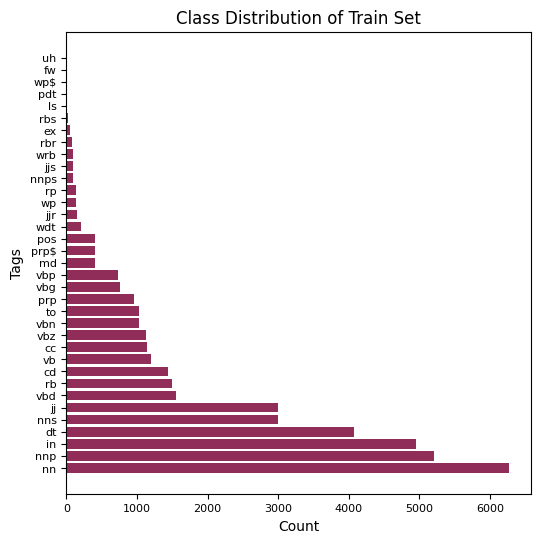

In [42]:
plot_data_distribution(tag_train, name="Train Set")

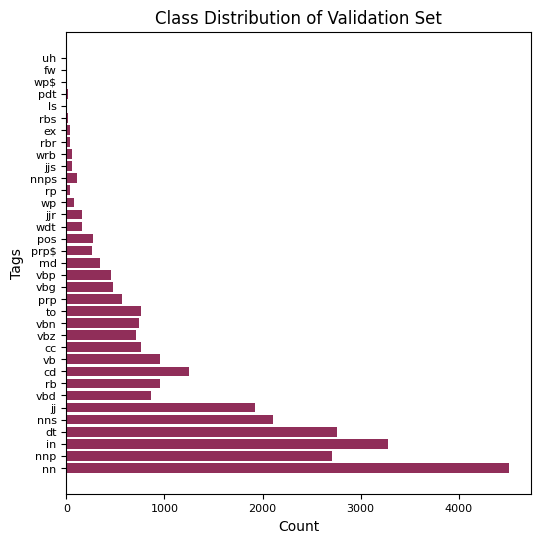

In [43]:
plot_data_distribution(tag_val, name="Validation Set")

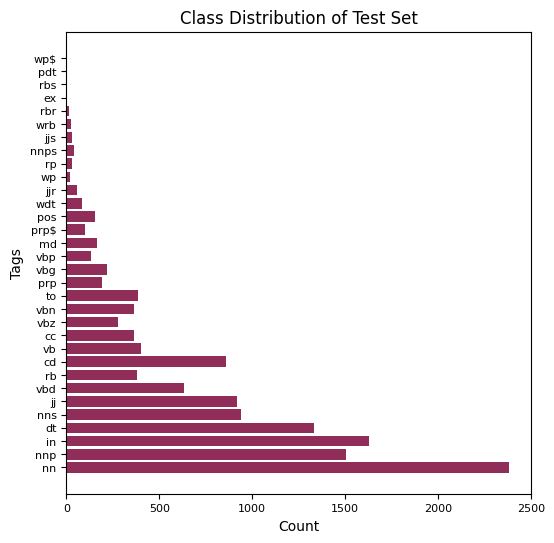

In [44]:
plot_data_distribution(tag_test, name="Test Set")

In [45]:
def get_cf_report(tag_pred, tag):
    cf_report_val = pd.DataFrame(
        classification_report(
            tag_pred.flatten(),
            tag.flatten(),
            labels=all_tokens,
            target_names=all_classes,
            zero_division=0,
            output_dict=True,
        )
    ).transpose()
    cf_report_val.reset_index(inplace=True)
    cf_report_val.columns = ["tags", "precision", "recall", "f1-score", "support"]

    print(
        "F1 score calculated on validation set:",
        f1_score(
            tag_pred.flatten(),
            tag.flatten(),
            labels=all_tokens,
            zero_division=0,
            average="macro",
        ),
        "\n",
    )
    return cf_report_val

In [46]:
### Display classification report for Validation Set
cf_report_val = get_cf_report(tag_pred_val, tag_val)
display(cf_report_val)

F1 score calculated on validation set: 0.6588640191543864 



,tags,precision,recall,f1-score,support
0,nn,0.824064,0.843502,0.833670,4409.0
1,nnp,0.833580,0.713743,0.769021,3158.0
2,in,0.966107,0.973239,0.969660,3251.0
3,dt,0.990922,0.990922,0.990922,2754.0
4,nns,0.751665,0.870523,0.806740,1815.0
5,jj,0.815489,0.636511,0.714969,2465.0
6,",",0.999346,1.000000,0.999673,1527.0
7,.,0.997651,0.996870,0.997260,1278.0
8,vbd,0.850174,0.832765,0.841379,879.0
9,rb,0.806519,0.815957,0.811211,940.0


In [47]:
### Display classification report for Test Set
cf_report_test = get_cf_report(tag_pred_test, tag_test)
display(cf_report_test)

F1 score calculated on validation set: 0.677795275627895 



,tags,precision,recall,f1-score,support
0,nn,0.800671,0.876033,0.836659,2178.0
1,nnp,0.859043,0.748552,0.800000,1726.0
2,in,0.960736,0.973881,0.967264,1608.0
3,dt,0.990262,0.987304,0.988781,1339.0
4,nns,0.804463,0.862187,0.832325,878.0
5,jj,0.808279,0.626160,0.705659,1185.0
6,",",0.998729,1.000000,0.999364,786.0
7,.,1.000000,0.995320,0.997654,641.0
8,vbd,0.876972,0.886762,0.881840,627.0
9,rb,0.800525,0.822102,0.811170,371.0


In [88]:
### Plot: class frequency(column) vs f1 score per model (scatter)

title_font = {
    "size": 28,
    "weight": "bold",
}
x_axis_font = {
    "size": 20,
}
y_axis_font = {
    "size": 22,
}
legend_title_font = {"weight": "bold", "size": 22}


def plot_freq_vs_f1(f1s, data, model_names, macro=True):

    class_frequencies = np.array(list(data.values()))
    class_frequencies = class_frequencies / (np.max(class_frequencies))
    class_names = [k.upper() for k in data.keys()]
    color_list = ["orange", "red", "aqua"]
    marker_list = ["v", "^", "s"]  # s

    # plt.rcParams.update({"text.usetex": True})
    # plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

    if macro:
        x_labels = ["Macro"] + class_names
    else:
        x_labels = ["Macro"] + class_names
    plt.title("F1 scores of each model", fontdict=title_font)
    plt.xlabel("Category", fontdict=y_axis_font)
    plt.ylabel("F1 scores", fontdict=x_axis_font)
    plt.xticks(
        ticks=range(len(f1s[0])), labels=x_labels, rotation="vertical", fontsize=20
    )
    # markersize = np.array([60, 30, 20])
    #  plt.yscale("log")

    plt.bar(
        x=np.arange(len(class_frequencies)),
        height=(class_frequencies),
        width=0.5,
        color=(0.7, 0.7, 0.7, 0.3),
        edgecolor="black",
        label="Tag support",
        alpha=0.8,
    )

    for s, color, label, marker in zip(  # ,ms
        f1s,
        color_list,
        model_names,
        marker_list,  # markersize
    ):
        plt.scatter(
            x=range(len(s)), y=s, c=color, label=label, marker=marker
        )  # , s=ms)
        plt.plot(range(len(s)), s, color=color, linewidth=0.6, linestyle="--")

    plt.legend(
        fontsize=20,
        title="Models",
        facecolor=(0.9, 0.9, 0.9),
        title_fontproperties=legend_title_font,
        loc="upper right",
        # ncols=3,
        # draggable=True, ### does not work on vscode
    )

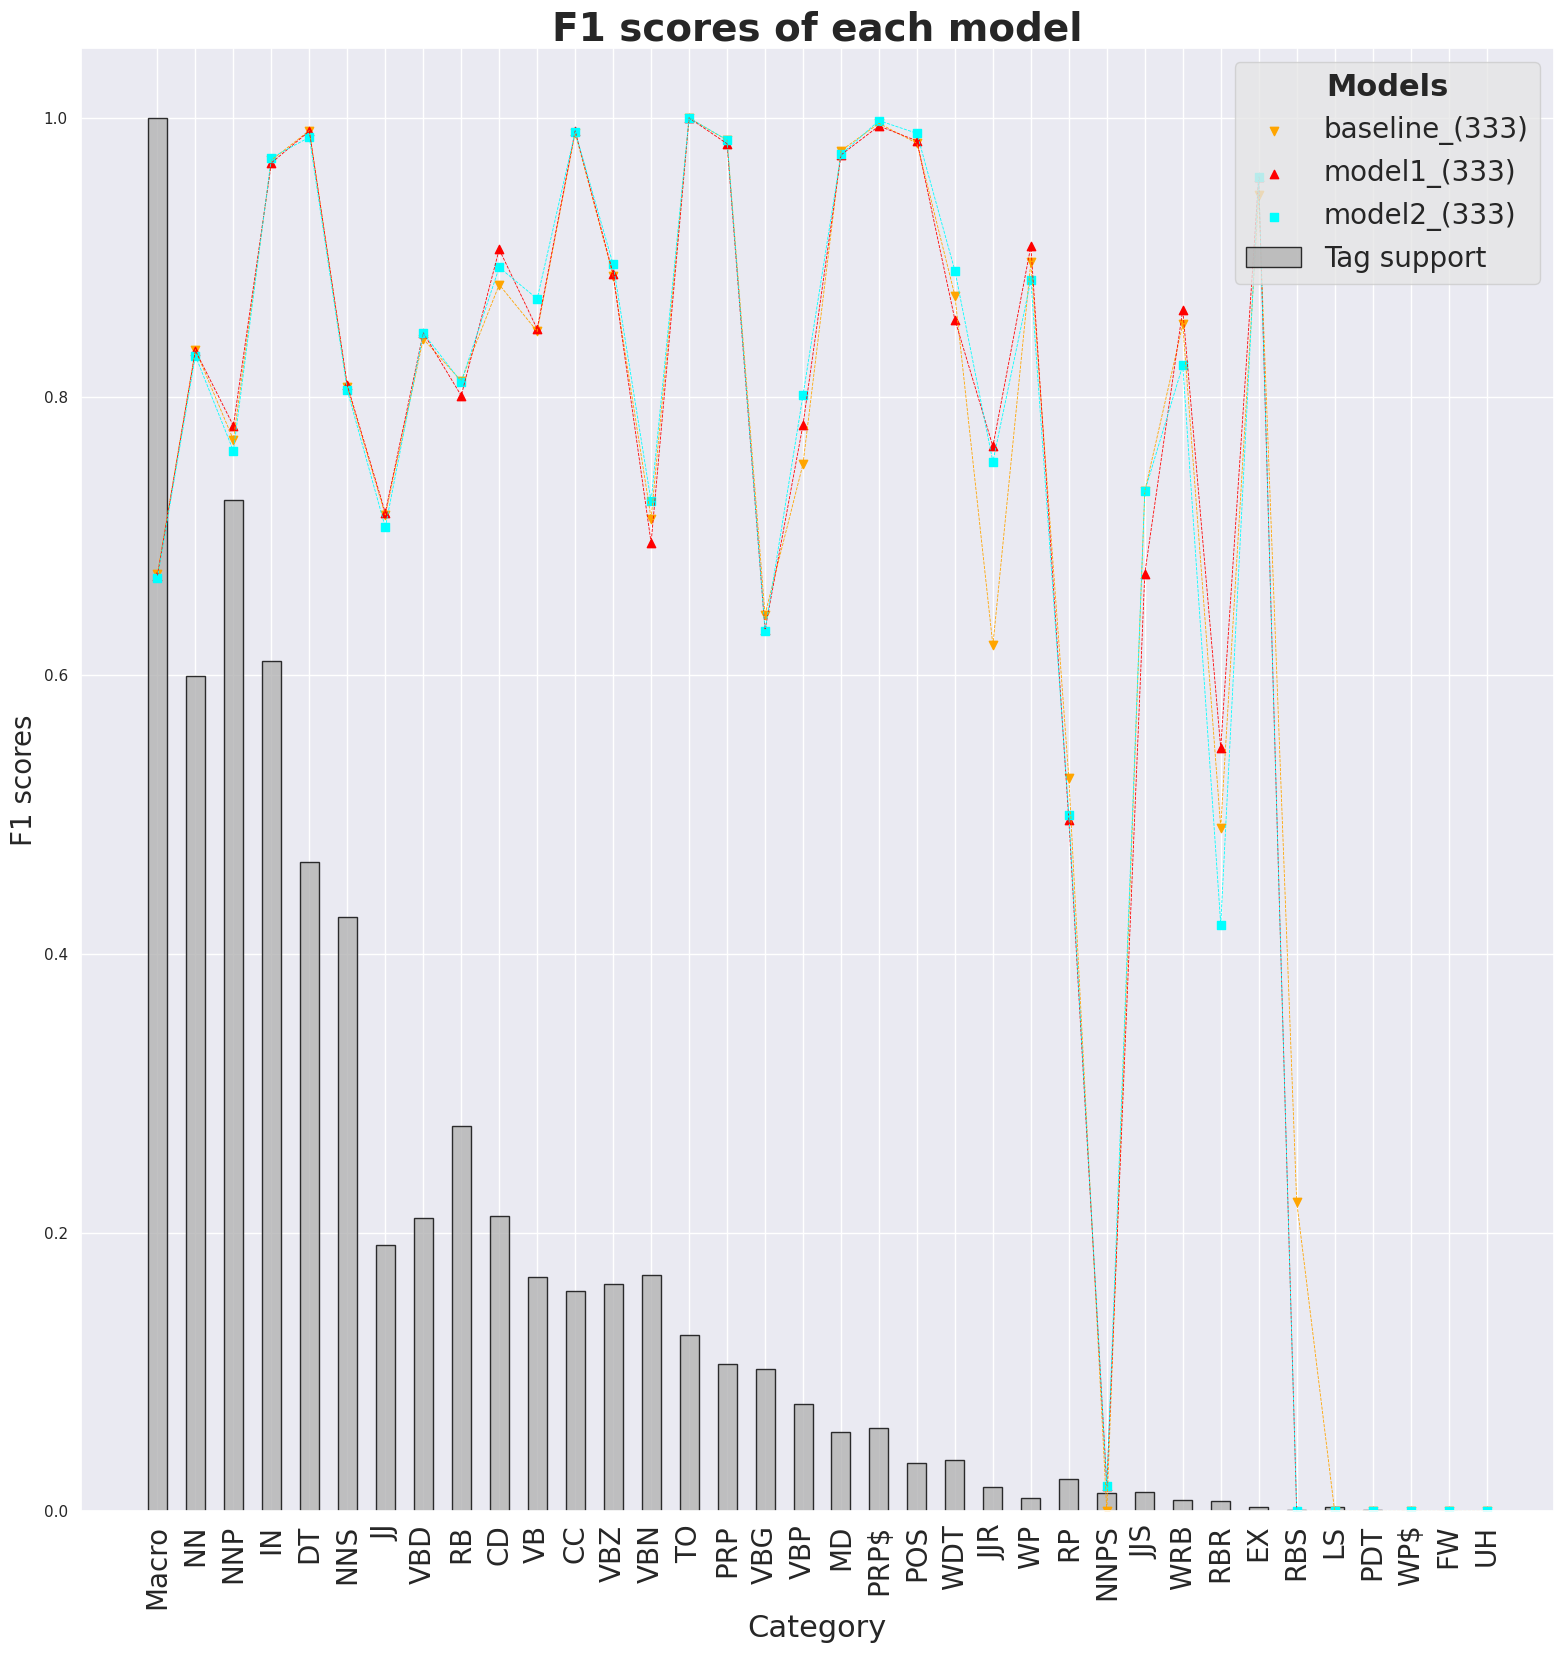

In [89]:
plot_freq_vs_f1(
    f1s=val_score_per_cat_per_kind,
    data=get_data_distribution(tag_val, sort=False),
    model_names=best_model_name_per_kind,
)
plt.savefig(
    "images/plot_f1_val.png",
    dpi=300,
)

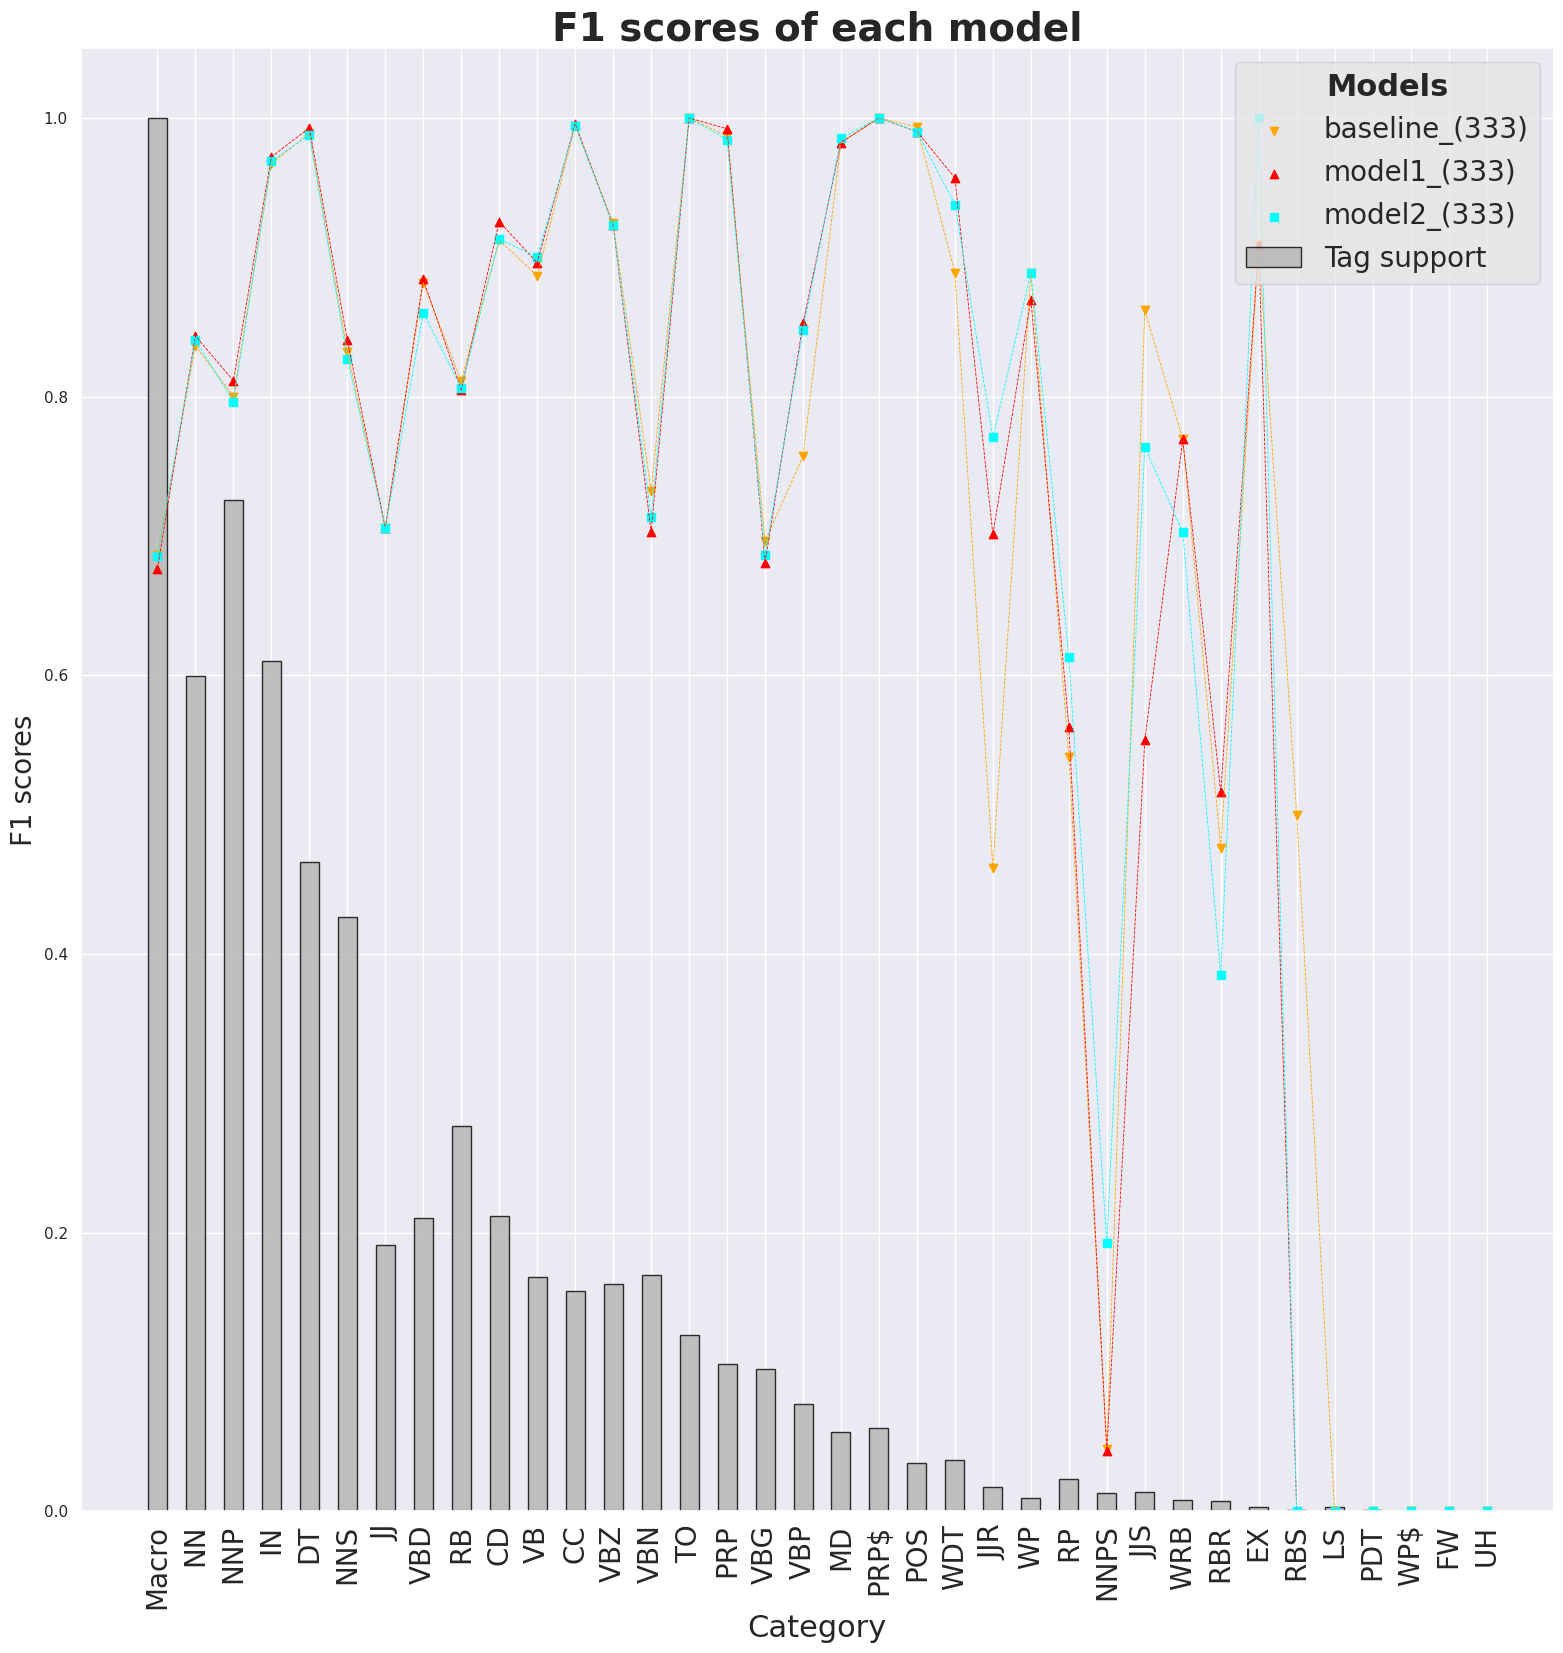

In [90]:
plot_freq_vs_f1(
    f1s=test_score_per_cat_per_kind,
    data=get_data_distribution(tag_val, sort=False),
    model_names=best_model_name_per_kind,
)
plt.savefig("images/plot_f1_test.png", dpi=300)

In [91]:
test_score_per_cat_per_kind_pruned = [e[10:-10] for e in test_score_per_cat_per_kind]
val_score_per_cat_per_kind_pruned = [e[10:-10] for e in val_score_per_cat_per_kind]
dist = get_data_distribution(tag_val, sort=False)
dist_pruned = dict(list(dist.items())[10:-10])

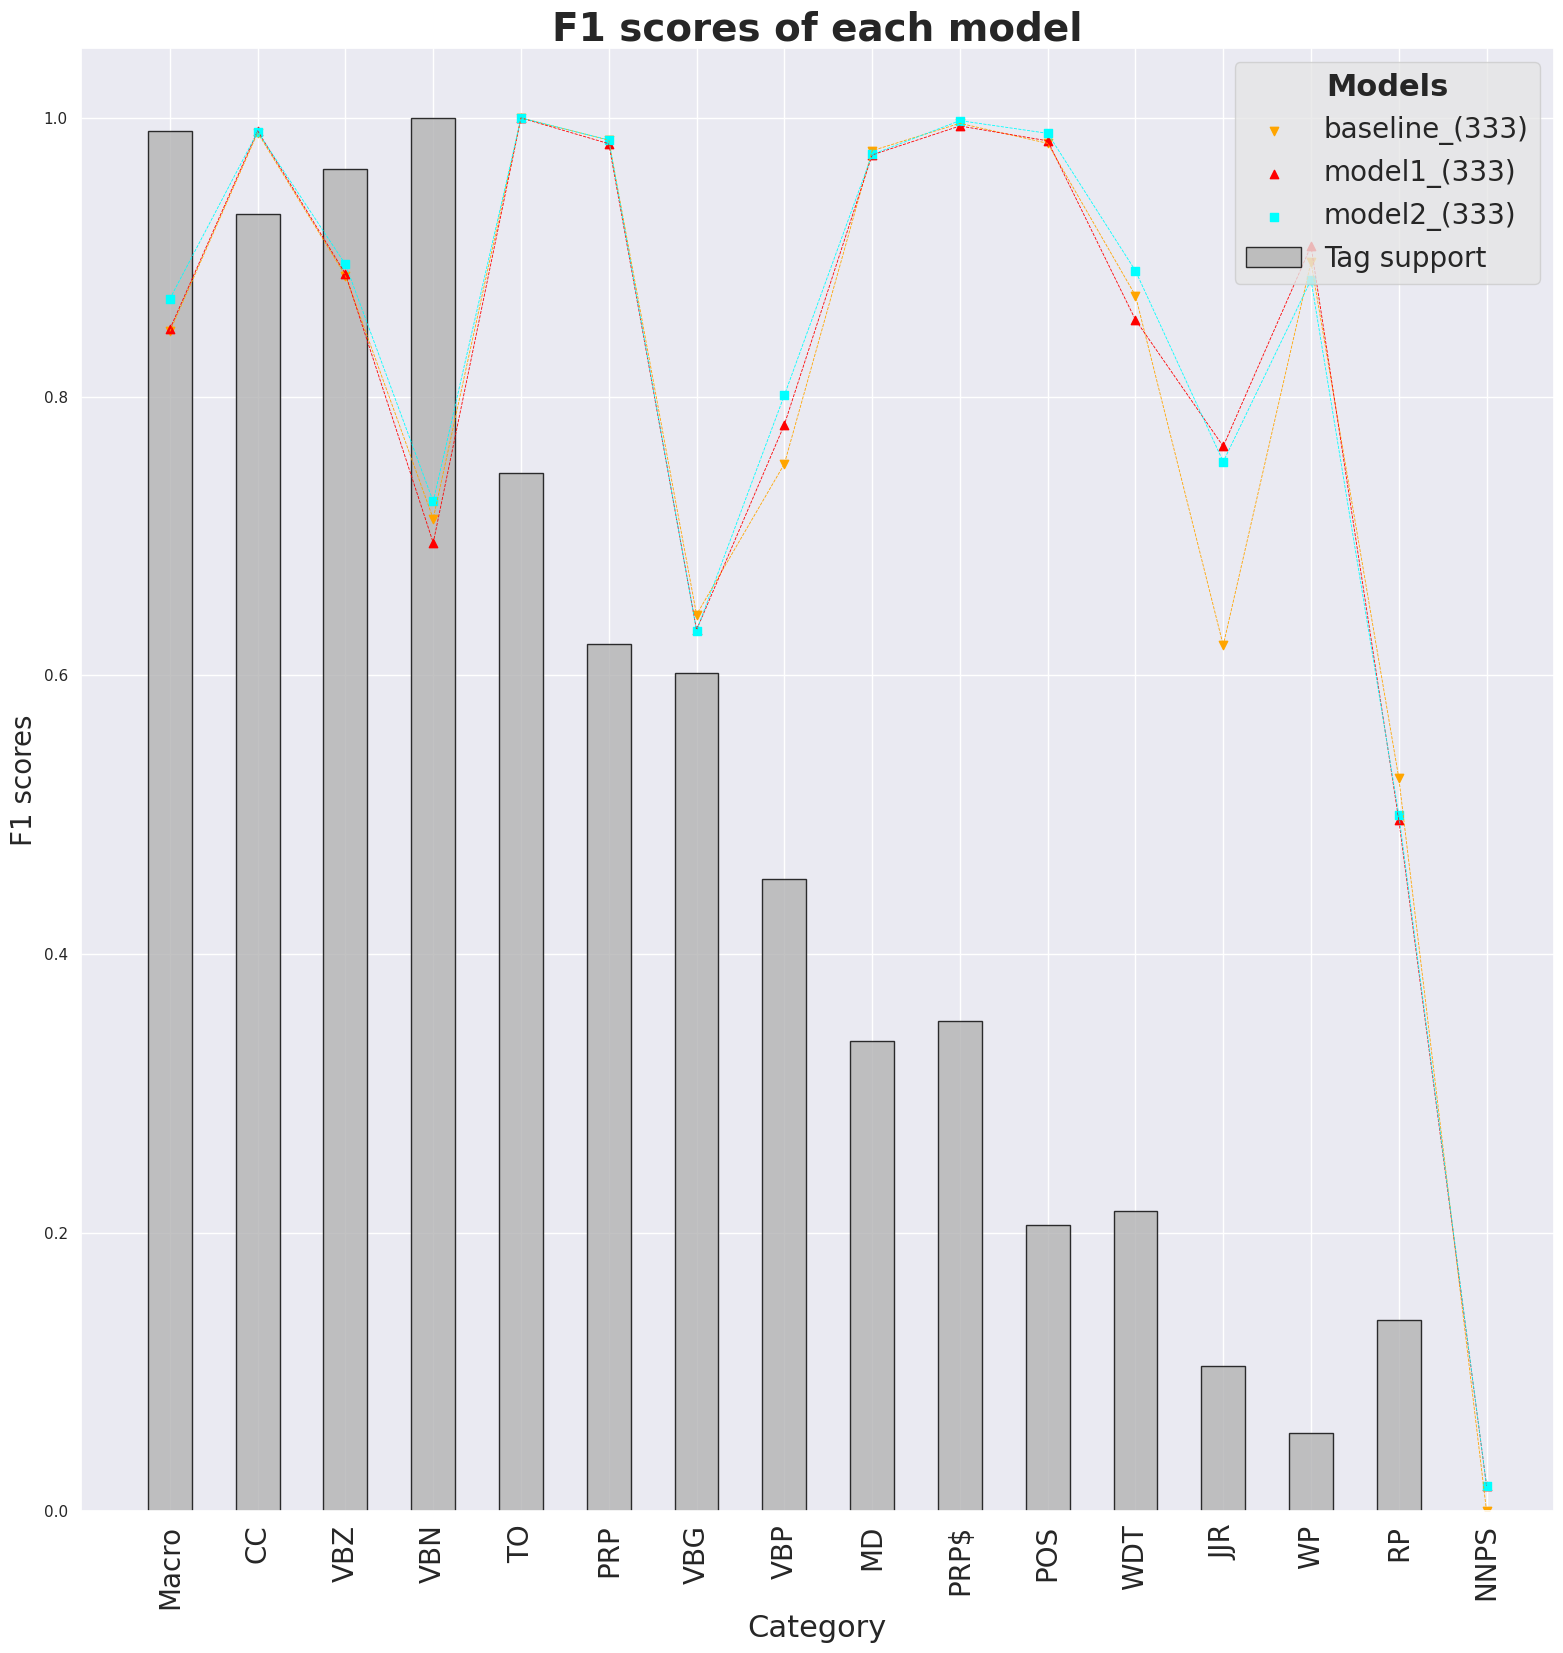

In [92]:
plot_freq_vs_f1(
    f1s=val_score_per_cat_per_kind_pruned,
    data=dist_pruned,
    model_names=best_model_name_per_kind,
    macro=False,
)
plt.savefig("images/plot_f1_val_pruned.png", dpi=300)

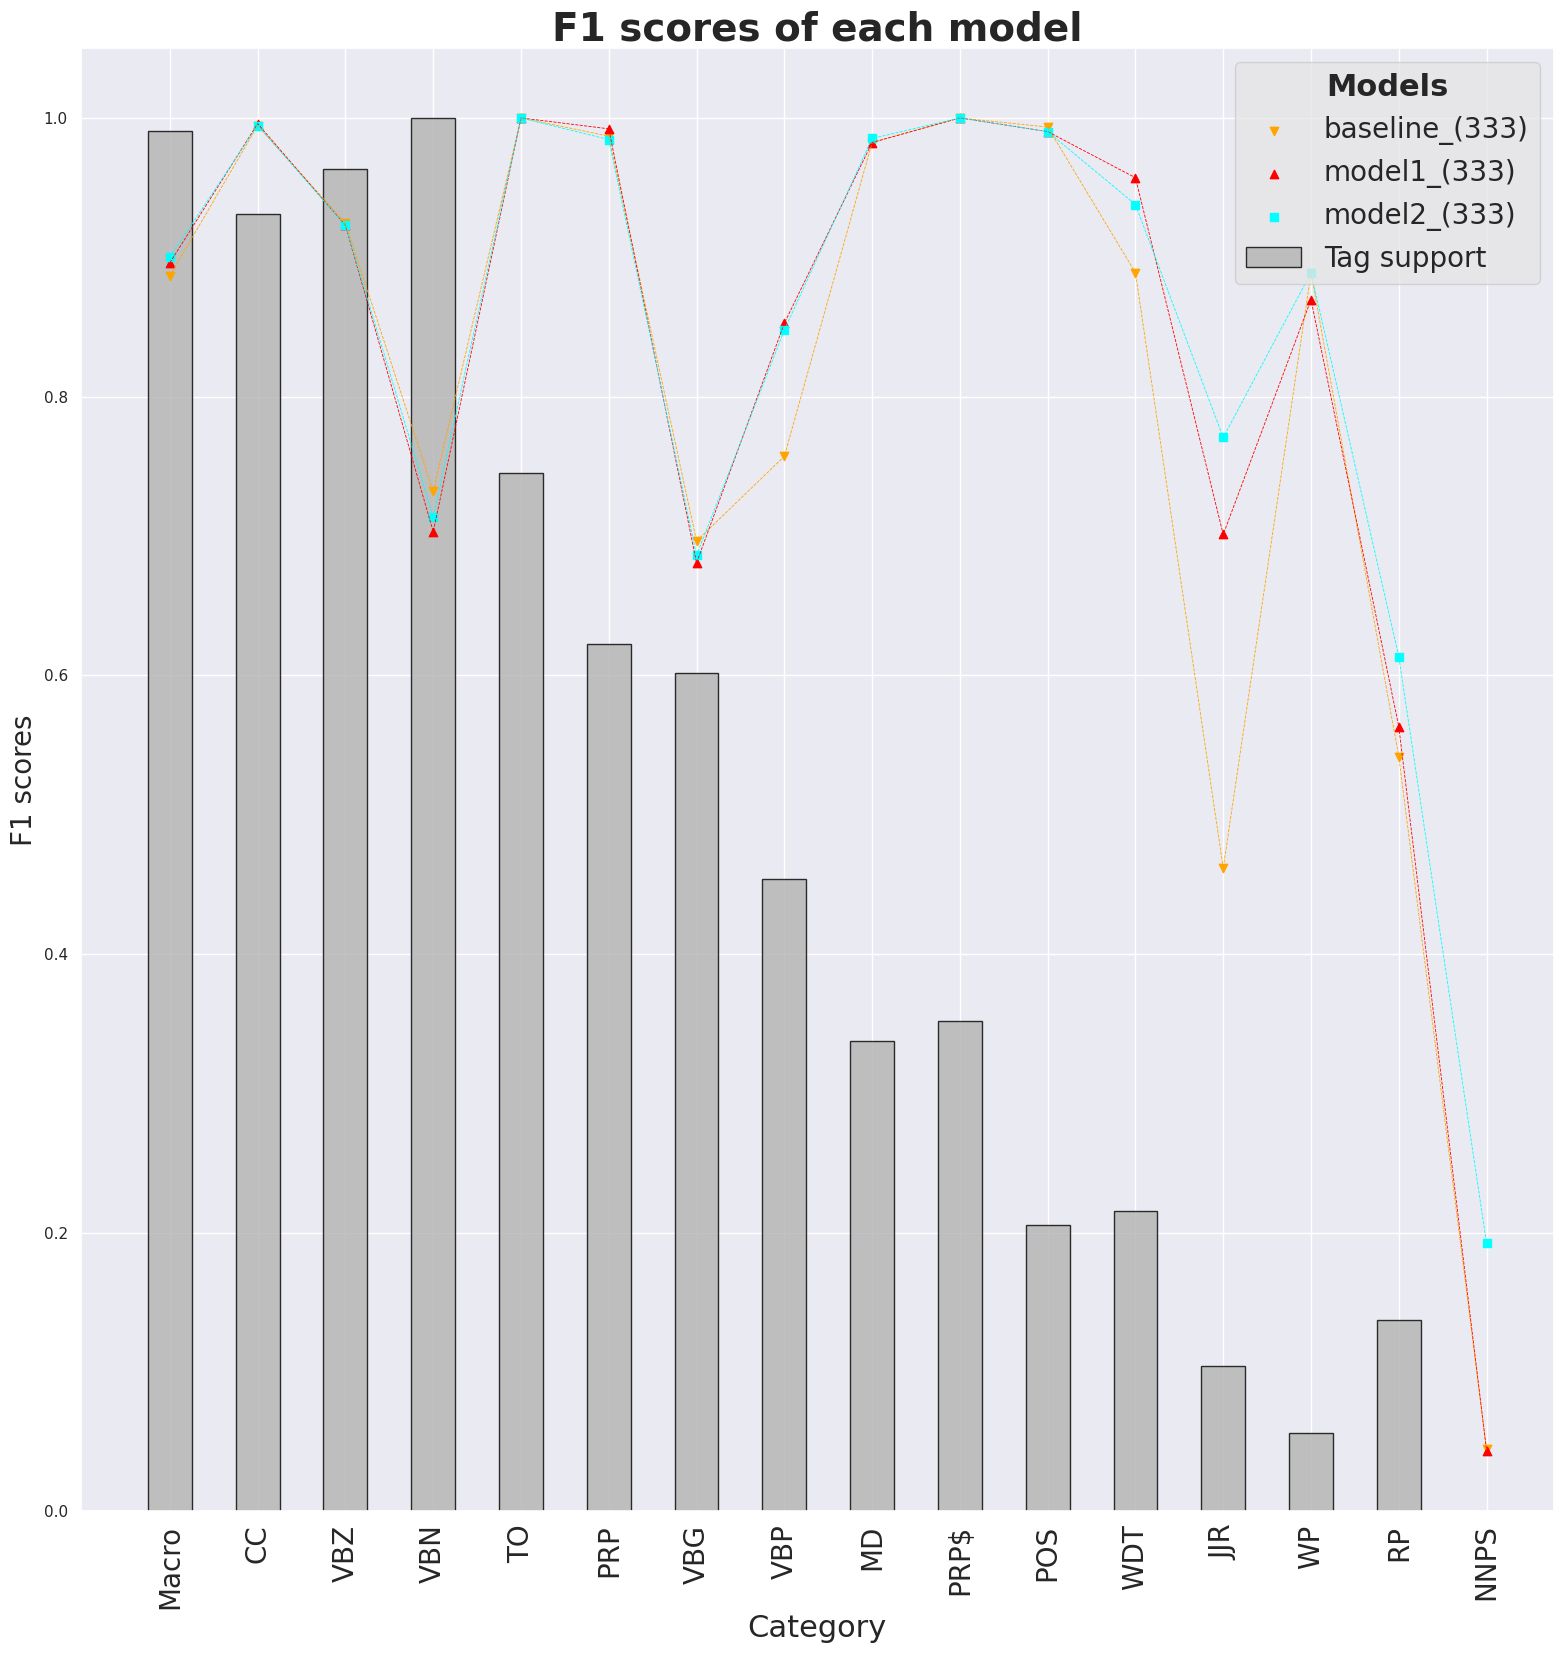

In [93]:
plot_freq_vs_f1(
    f1s=test_score_per_cat_per_kind_pruned,
    data=dist_pruned,
    model_names=best_model_name_per_kind,
)
plt.savefig("images/plot_f1_test_pruned.png", dpi=300)

In [94]:
def plot_confusion_matrix(y_test, y_pred, name):
    cm = confusion_matrix(
        y_test.flatten(), y_pred.flatten(), labels=allowed_tokens, normalize="true"
    )
    np.set_printoptions(suppress=True)
    cm_df = pd.DataFrame(cm, index=allowed_classes, columns=allowed_classes)

    fig, ax = plt.subplots()
    sns.set(rc={"figure.figsize": (19, 19)})
    sns.heatmap(
        cm_df,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        annot_kws={"size": 8},
        ax=ax,
        cbar_kws={"shrink": 0.5},
    )
    ax.tick_params(labelsize=8)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix {name}")
    plt.show()

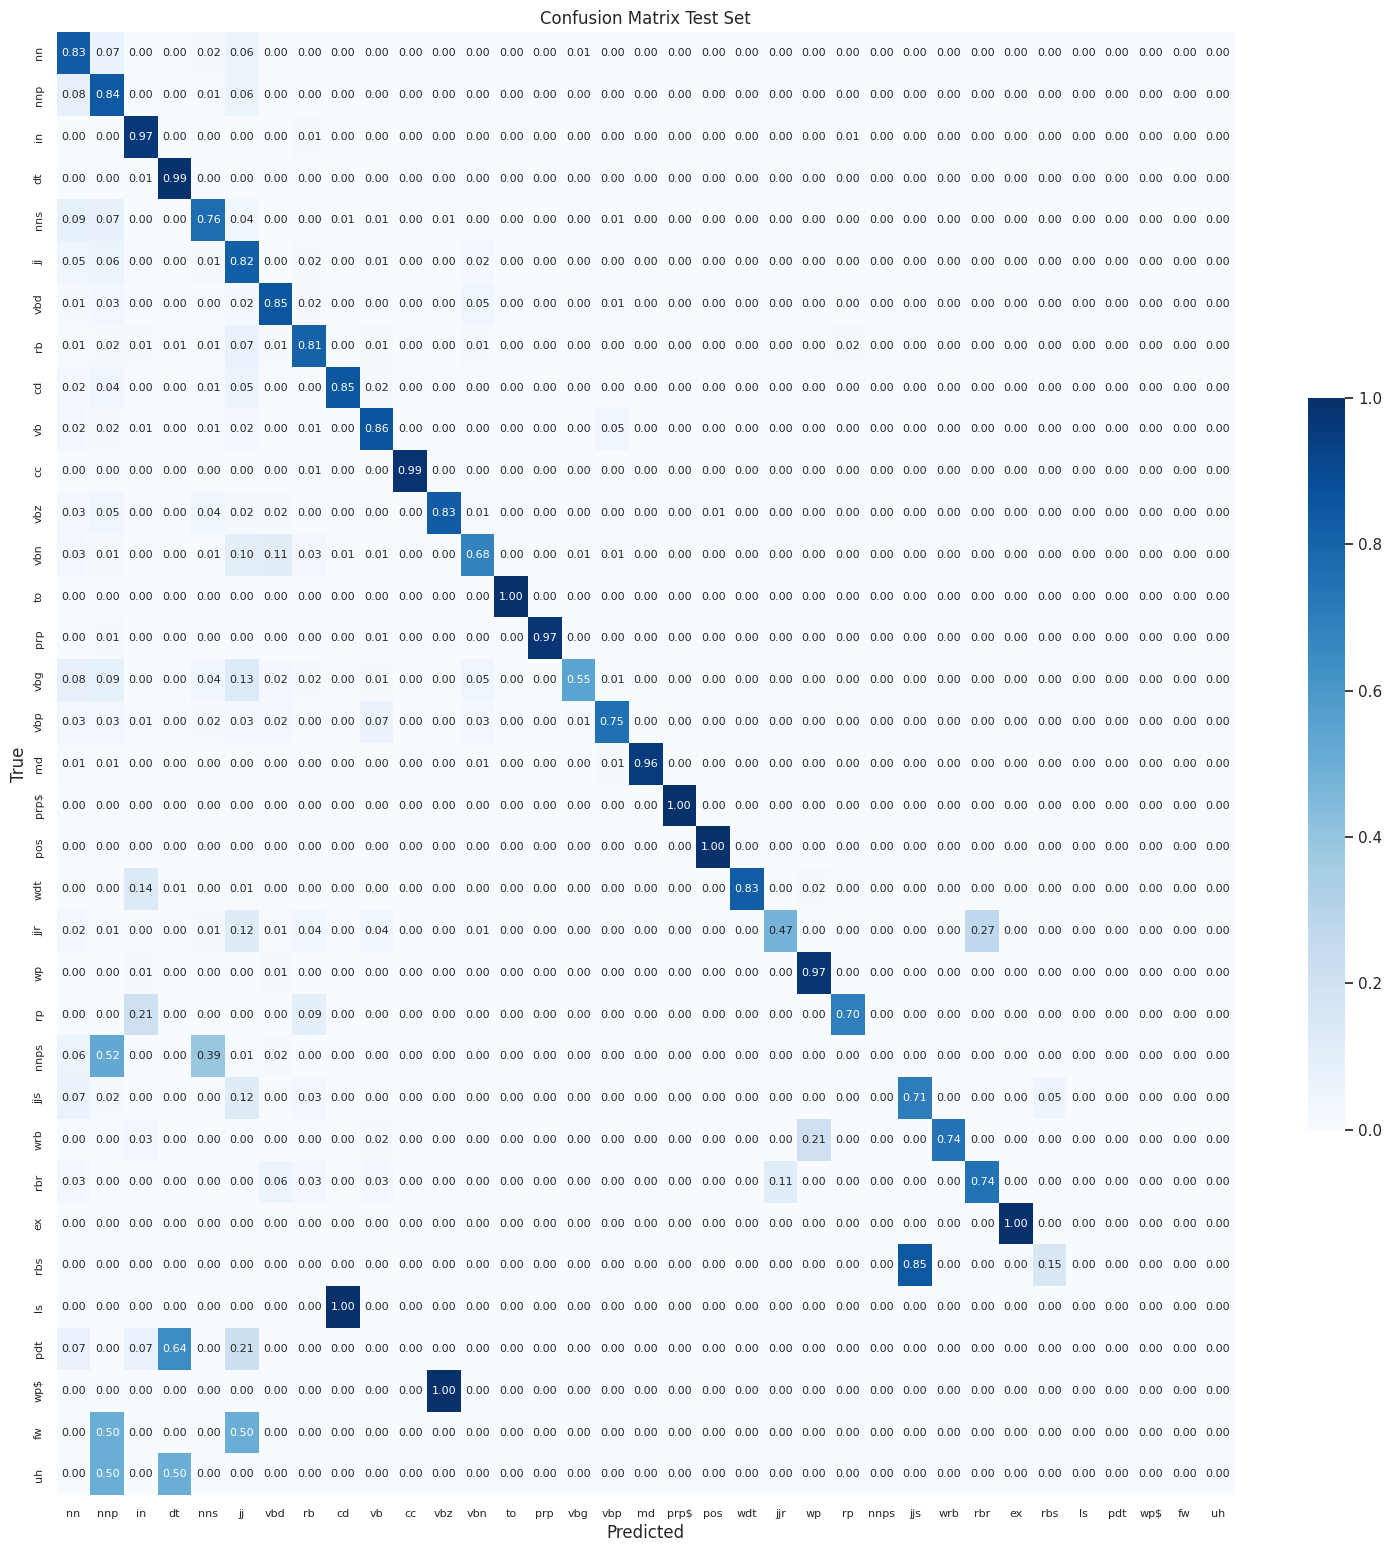

In [95]:
### Validation set confusion matrix
plot_confusion_matrix(tag_val, tag_pred_val, name="Test Set")

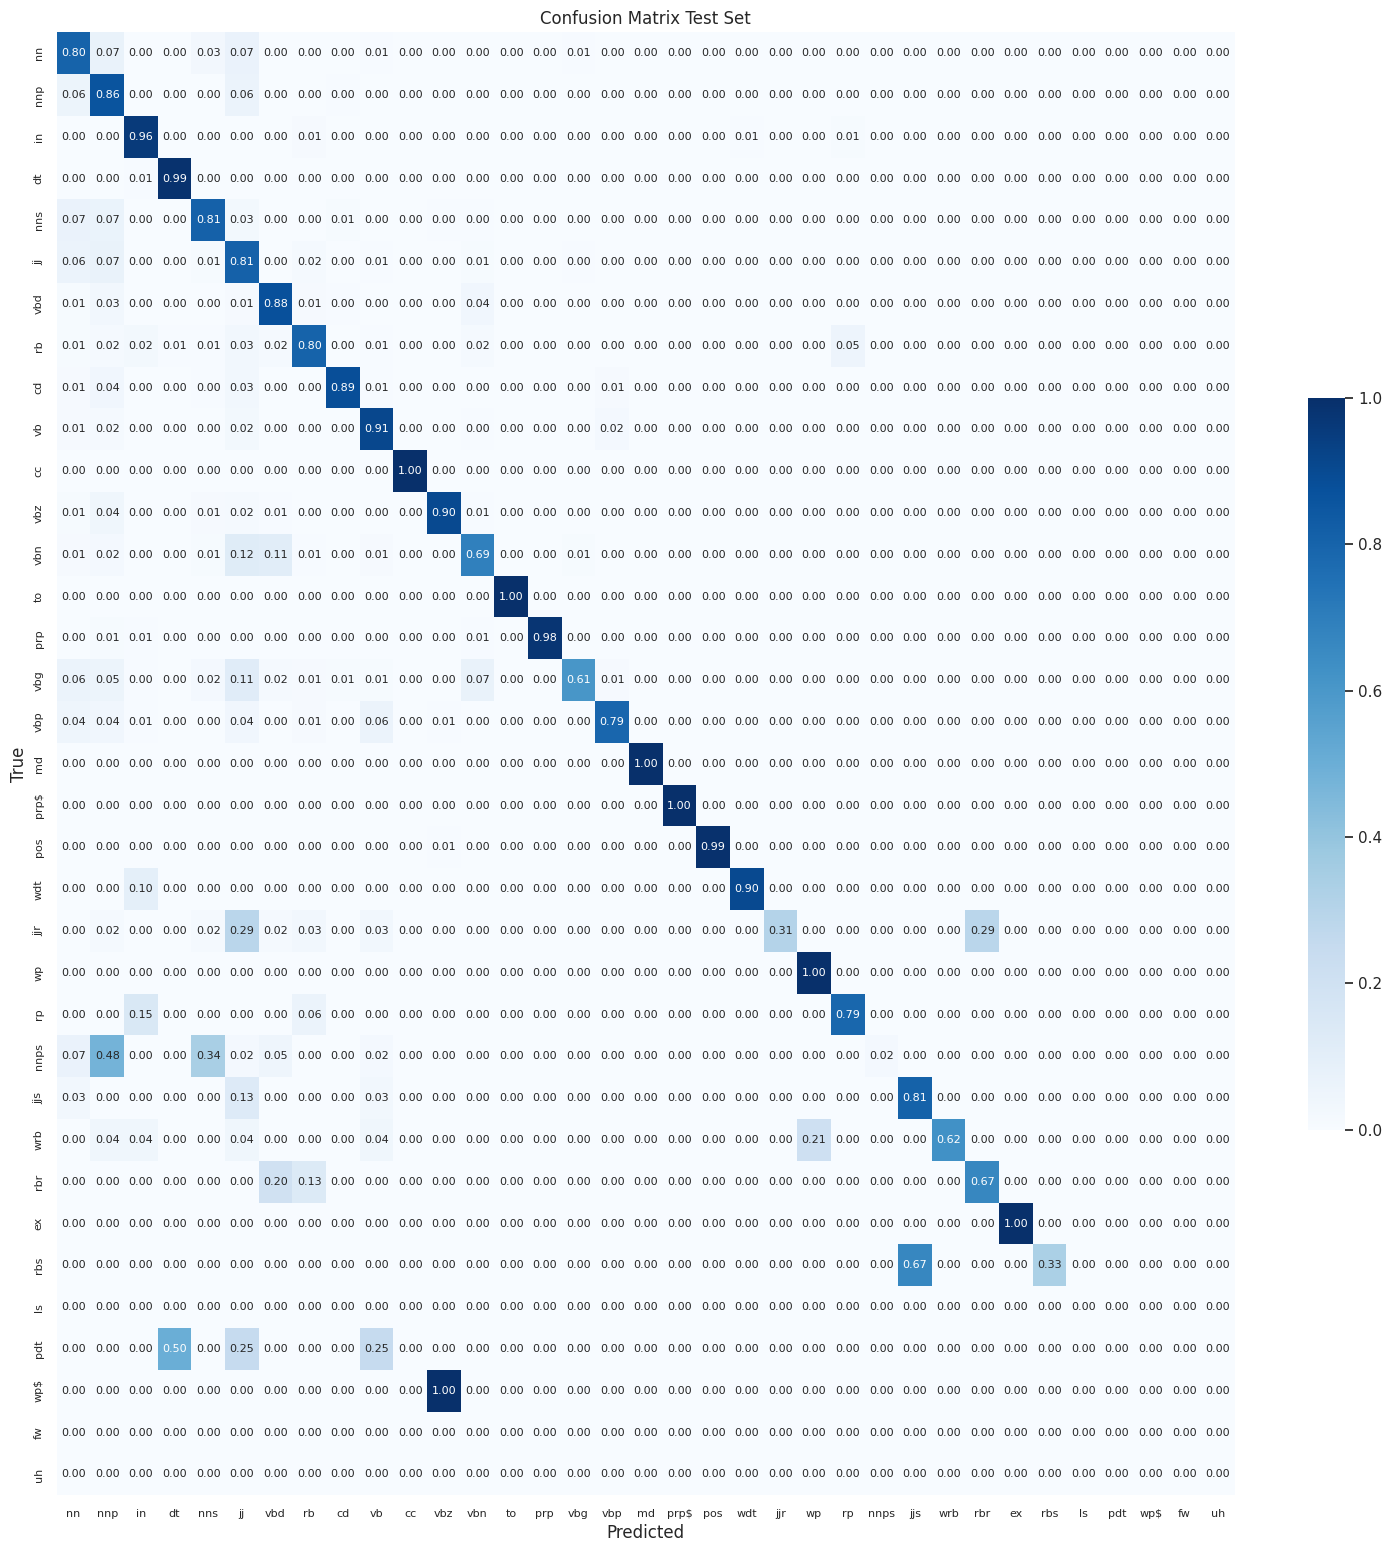

In [96]:
### Test set confusion matrix
plot_confusion_matrix(tag_test, tag_pred_test, name="Test Set")

In [97]:
def get_worst_n_classified_sentences(x_test, y_test, y_pred, n):
    scores = {}

    ### Get f1 score for each sentence
    for i in range(len(y_pred)):
        score = f1_score(
            y_pred[i],
            y_test[i],
            labels=allowed_tokens,
            zero_division=0,
            average="macro",
        )
        scores[x_test[i]] = score
    ### Put the scores into a df
    scores_df = pd.DataFrame(scores.items(), columns=["Sentence", "Score"])
    scores_df.sort_values(by=["Score"], ascending=True, inplace=True)
    return scores_df.iloc[:n]

In [98]:
### Inspect the worst classified sentences in Test Set
decoded_x_test = tokenizer.sequences_to_texts(text_test)
get_worst_n_classified_sentences(decoded_x_test, tag_test, tag_pred_test, 30)

,Sentence,Score
78,OOV and OOV : OOV OOV OOV OOV OOV OOV OOV OOV ...,0.000000
71,energy : OOV OOV OOV OOV OOV OOV OOV OOV OOV O...,0.000000
357,"dow jones industrials 2645.90 , up OOV ; trans...",0.009524
401,business : savings and loan OOV OOV OOV OOV OO...,0.014286
456,"OOV inc . -lrb- chandler , ariz. -rrb- -- OOV ...",0.025397
355,markets -- OOV OOV OOV OOV OOV OOV OOV OOV OOV...,0.028571
86,OOV : OOV OOV OOV OOV OOV OOV OOV OOV OOV OOV ...,0.028571
360,"dollar : 143.80 yen , up OOV ; 1.8500 marks , ...",0.030476
356,stocks : volume OOV shares . OOV OOV OOV OOV O...,0.057143
221,OOV OOV electronic devices and OOV power suppl...,0.059592


# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End